
### **Customer Behavior Compression and Prediction in E-Commerce Using PCA + ML**

An e-commerce platform wants to understand customer behavior across dozens of variables (age, frequency, spend per category, returns, discount usage, etc.).
We apply PCA to simplify and visualize customer types, reduce noise for modeling, and make actionable clusters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
retail_data = pd.read_csv("Online Retail.csv",encoding='ISO-8859-1')
#encoding used to avoid utf-8 error and to handle UK/EU charcaters
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 8:26,3.39,17850.0,United Kingdom


In [6]:
retail_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [16]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Description and Customer Id has some missing values, we will not clean **description** as this data will not hold much significance with problem statement, we have to drop **Customer IDs** as these can't be tracked and imputation is not possible on fact data

In [23]:
retail_data = retail_data.dropna(subset=['CustomerID'])


In [24]:
 #Remove cancelled orders (identification -> InvoiceNo starting with 'C')
retail_data = retail_data[~retail_data['InvoiceNo'].astype(str).str.startswith('C')]

In [25]:
customer_df = retail_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'InvoiceNo': 'nunique',
    'Description': 'count',
    'Country': 'first'
}).rename(columns={
    'Quantity': 'TotalQuantity',
    'UnitPrice': 'AvgUnitPrice',
    'InvoiceNo': 'PurchaseFrequency',
    'Description': 'TotalItems'
}).reset_index()


In [26]:
customer_df.head(2)

,CustomerID,TotalQuantity,AvgUnitPrice,PurchaseFrequency,TotalItems,Country
0,12346.0,74215,1.040000,1,1,United Kingdom
1,12347.0,2458,2.644011,7,182,Iceland


We will also need to check for Outliers, as this will tilt the principle component line and also create problems while doing K means clustering

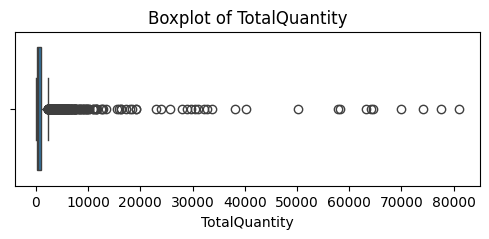

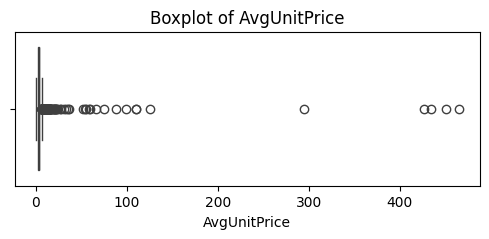

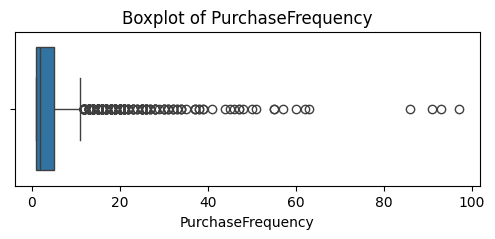

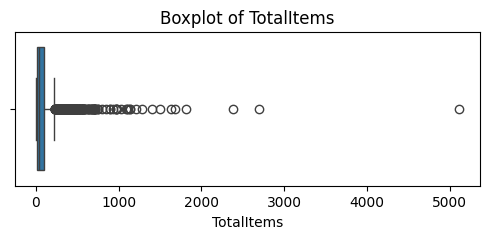

In [40]:

import seaborn as sns
import matplotlib.pyplot as plt

features = ['TotalQuantity', 'AvgUnitPrice', 'PurchaseFrequency', 'TotalItems']

for col in features:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=customer_df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


Each columns has some outliers, Let's use IQR method to remove these outliers

In [41]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in features:
    customer_df = remove_outliers_iqr(customer_df, col)


Since, we have removed the outliers and updated our customer_df dataframe, we can apply PCA algo here to visualize this data

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [43]:
features = ['TotalQuantity', 'AvgUnitPrice', 'PurchaseFrequency', 'TotalItems']
X = customer_df[features]


Standardizing the data is necessary before doing PCA. It helps in
1. All features contribute equally by eliminating the effect of different scales
2. Features are centered around zero (mean = 0) and scaled (std dev = 1)
3. Variables with larger magnitudes do not dominate the principal components

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [45]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Attach PCs to original data
customer_df['PC1'] = X_pca[:, 0]
customer_df['PC2'] = X_pca[:, 1]

# Explained Variance
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.55792055 0.25888726]


Principal Component 1 explains approximately 56% of the total variance, while Principal Component 2 accounts for another 26%, meaning that together, the first two components capture 82% of the variability in the original data. This dimensionality reduction retains the majority of the information while simplifying the dataset from 4 features to 2.

Remaining 18% = noise, less relevant patterns



A scree plot shows how much variance each principal component captures.
It helps decide how many components to keep by visualizing the “elbow point” — where adding more components gives diminishing returns.
In this project, the first two components captured ~82% of the total variance, so reducing from 4D to 2D was both efficient and justifiable.

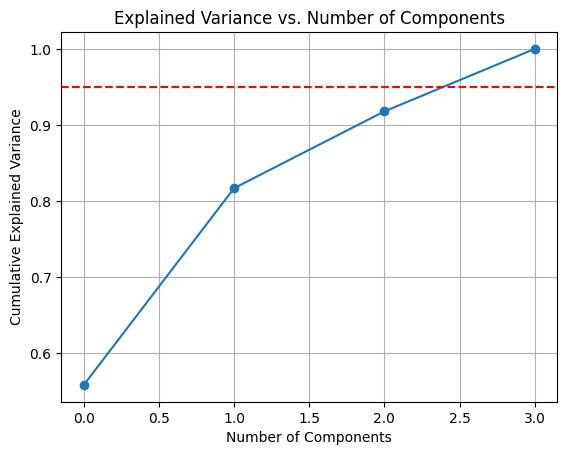

In [47]:

pca_full = PCA()
pca_full.fit(X_scaled)

plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid(True)
plt.show()


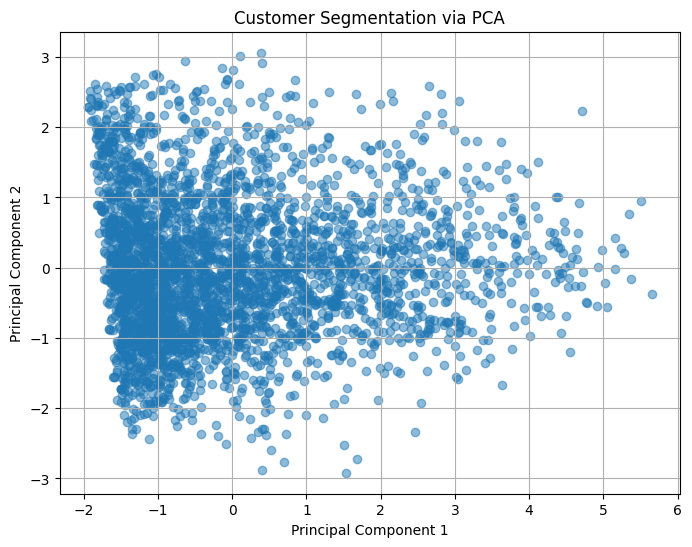

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(customer_df['PC1'], customer_df['PC2'], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Segmentation via PCA")
plt.grid(True)
plt.show()


This scatter plot shows each customer projected into a 2D space using the top two principal components derived from their purchasing behavior.
Even without clustering, the plot reveals natural spread and density patterns, indicating underlying customer groupings.
The X-axis (PC1) captures the most variance in purchase quantity and frequency, while the Y-axis (PC2) reflects variation in unit price and product diversity.

In [65]:
components_df = pd.DataFrame(
    pca.components_, 
    columns=['TotalQuantity', 'AvgUnitPrice', 'PurchaseFrequency', 'TotalItems'],
    index=['PC1', 'PC2']
)

print(components_df)

     TotalQuantity  AvgUnitPrice  PurchaseFrequency  TotalItems
PC1       0.585362     -0.086979           0.569690    0.570298
PC2      -0.131808      0.964002           0.223155    0.059397


**PC1** is mostly made up of:
TotalQuantity + PurchaseFrequency (since both have large weights)
-> So PC1 measures buying behavior or order volume

**PC2** is mostly made up of:
AvgUnitPrice and TotalItems
-> So PC2 captures spending pattern (high vs low priced products)

Thus,
Principal Component 1 was heavily influenced by quantity and frequency, indicating buying volume.
Principal Component 2 was driven by unit price and total items, capturing customer pricing behavior.

**Now Let's do customer segmentation using K means clustering after PCA has applied**

We use the first two principal components as input to KMeans to identify natural customer groupings. This helps us visualize customer behavior in 2D while retaining 80%+ of the original data's variance.


In [48]:
from sklearn.cluster import KMeans

In [49]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['Segment'] = kmeans.fit_predict(customer_df[['PC1', 'PC2']])


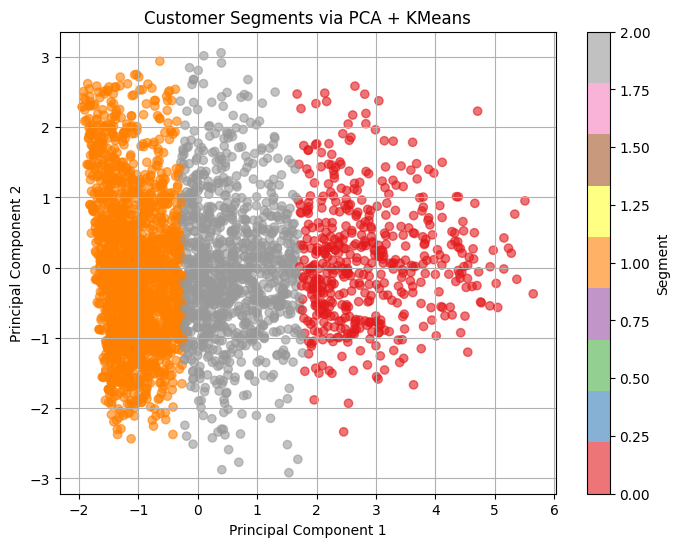

In [52]:
plt.figure(figsize=(8,6))
plt.scatter(customer_df['PC1'], customer_df['PC2'], c=customer_df['Segment'], cmap='Set1', alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Segments via PCA + KMeans")
plt.grid(True)
plt.colorbar(label="Segment")
plt.show()


In [53]:
customer_df.groupby('Segment')[['TotalQuantity', 'AvgUnitPrice', 'PurchaseFrequency', 'TotalItems']].mean()


,TotalQuantity,AvgUnitPrice,PurchaseFrequency,TotalItems
Segment,,,,
0,1207.749487,2.863884,5.209446,104.995893
1,189.530444,3.091274,1.362041,20.831048
2,565.984158,2.919125,2.977228,58.414851


1. Segment 0 are **High Quantity** and **High Frequency** (Mostly Loyal customers)
2. Segment 1 are **Low Quantity** and **Low Frequency** (Mostly Promo driven customers)
3. Segment 2 are **High Price** and  **low frequency** (premium Customer - High AOV)

#### Let's build Decision Tree classifier to predict customer purchase behaviour

This decision tree was trained on customer purchase behavior to predict their assigned segment.
It breaks down customer types based on thresholds like Total Quantity, Purchase Frequency, and Avg Unit Price to classify them into 3 segments.
The tree structure highlights which features are most influential and how the model makes decisions — making it fully transparent and explainable.

To validate if the segments are truly distinguishable, we train a Decision Tree classifier to predict cluster labels using original features.


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Features and Target
X_ml = customer_df[['TotalQuantity', 'AvgUnitPrice', 'PurchaseFrequency', 'TotalItems']]
y_ml = customer_df['Segment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)


In [56]:
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=4, random_state=42)

In [57]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 93   0  17]
 [  0 341  16]
 [ 14  19 164]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       110
           1       0.95      0.96      0.95       357
           2       0.83      0.83      0.83       197

    accuracy                           0.90       664
   macro avg       0.88      0.88      0.88       664
weighted avg       0.90      0.90      0.90       664



The Decision Tree classifier achieved 90% overall accuracy in predicting customer segments.
It performed best on Segment 1 (F1-score: 0.95), while Segment 2 had slightly lower recall (0.83), indicating a few misclassifications.

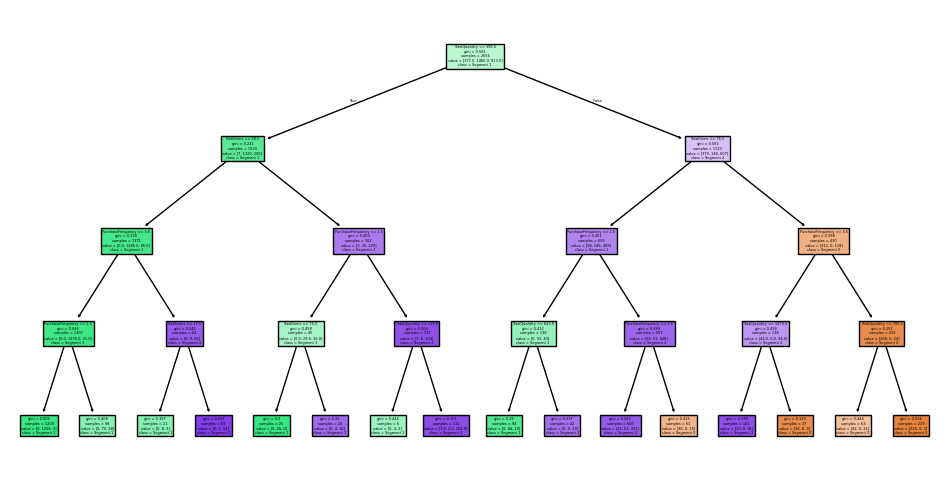

In [58]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 6))
plot_tree(model, feature_names=X_ml.columns, class_names=['Segment 0', 'Segment 1', 'Segment 2'], filled=True)
plt.show()


Even though clustering was unsupervised, we successfully trained a model that can classify future customers into segments based on shopping behavior.



Since result for decision tree classifier is not upto the mark, Let's do random tree classifier to improve the model accuracy, even if this model will be unable to get good accuracy will try different models

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [60]:
feature_cols = ['TotalQuantity', 'AvgUnitPrice', 'PurchaseFrequency', 'TotalItems']
X = customer_df[feature_cols]
y = customer_df['Segment']


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

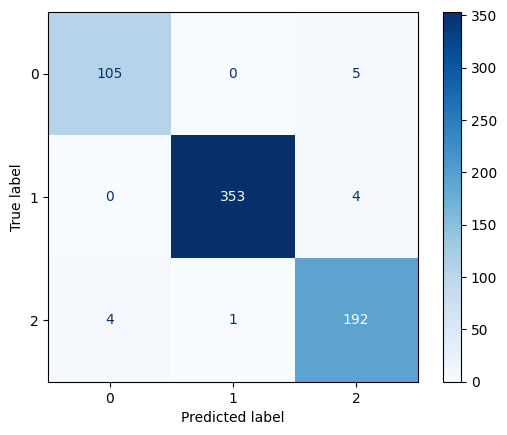

In [63]:
y_pred = rf_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')


In [64]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.95      0.96       110
           1       1.00      0.99      0.99       357
           2       0.96      0.97      0.96       197

    accuracy                           0.98       664
   macro avg       0.97      0.97      0.97       664
weighted avg       0.98      0.98      0.98       664



#### Using Random Forest on PCA-transformed customer behavior data, I achieved 98% accuracy in predicting segment labels with high precision and recall across all clusters.

Thus, Random Forest is best suited model for this dataset and problem statement

## Conclusion & Business Value

1. Reduced 4D data into 2D using PCA with minimal loss of information (82% variance retained)
2. Identified 3 distinct customer segments using unsupervised clustering
3. Validated those segments with Random Forest and Decision Tree models (98% & 90% accuracy respectively)
4. Provided interpretable insights using Decision Tree visualization

**Business Impact**:
1. Helps marketing teams target premium vs. loyal vs. occasional buyers
2. Enables personalization and retention strategies
